<a href="https://colab.research.google.com/github/Bhagyalakshmi-V-2025/python-jupyter-template/blob/main/Final_year_project_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Exploration

Importing Dependencies

In [ ]:
!pip install opencv-python
import os
import cv2
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

Paths to Dataset

In [ ]:
# Define paths to dataset
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"
annotations_dir =  "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"

# Verify directories exist
if not os.path.exists(images_dir) or not os.path.exists(annotations_dir):
    print("Error: Dataset directories do not exist!")
else:
    print("Dataset directories verified.")

Dataset directories verified.


Get the total file counts

In [ ]:
# Get file counts
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])
annotation_files = sorted([f for f in os.listdir(annotations_dir) if f.endswith(".xml")])

print(f"Number of images: {len(image_files)}")
print(f"Number of annotations: {len(annotation_files)}")

# Check for mismatches
image_base_names = {os.path.splitext(f)[0] for f in image_files}
annotation_base_names = {os.path.splitext(f)[0] for f in annotation_files}

missing_annotations = image_base_names - annotation_base_names
missing_images = annotation_base_names - image_base_names

print(f"Images without annotations: {missing_annotations}")
print(f"Annotations without images: {missing_images}")

Number of images: 2349
Number of annotations: 2349
Images without annotations: set()
Annotations without images: set()


Removing images without annotations

In [ ]:
# Remove images without annotations
for missing in missing_annotations:
    os.remove(os.path.join(images_dir, missing + ".png"))
    print(f"Removed image without annotation: {missing}.png")

# Remove annotations without images
for missing in missing_images:
    os.remove(os.path.join(annotations_dir, missing + ".xml"))
    print(f"Removed annotation without image: {missing}.xml")

Class Mapping

In [ ]:
import xml.etree.ElementTree as ET
from PIL import Image
import os

# Directory paths
images_path = "/content/drive/MyDrive/Colab/FY_project/EMDS7"
annotations_path = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"
yolo_labels_path = "/content/drive/MyDrive/Colab/FY_project/labels"

os.makedirs(yolo_labels_path, exist_ok=True)

names_list = ['Oscillatoria', 'Ankistrodesmus', 'Microcystis', 'Gomphonema', 'Sphaerocystis',
              'Cosmarium', 'Cocconeis', 'Tribonema', 'Chlorella', 'Tetraedron', 'Ankistrodesmus',
              'Brachionus', 'Chaenea', 'Pediastrum', 'Spirulina', 'Actinastrum', 'Navicula',
              'Scenedesmus', 'Golenkinia', 'Pinnularia', 'Staurastrum', 'Phormidium', 'Fragilaria',
              'Anabaenopsis', 'Coelosphaerium', 'Crucigenia', 'Achnanthes', 'Synedra', 'Ceratium',
              'Pompholyx', 'Merismopedia', 'Spirogyra', 'Coelastrum', 'Raphidiopsis', 'Gomphosphaeria',
              'Euglena', 'Euclanis', 'Keratella', 'diversicornis', 'Surirella', 'Characium']

# Generate class mapping
class_mapping = {f"G{i+1:03}": name for i, name in enumerate(names_list)}
print(class_mapping)

{'G001': 'Oscillatoria', 'G002': 'Ankistrodesmus', 'G003': 'Microcystis', 'G004': 'Gomphonema', 'G005': 'Sphaerocystis', 'G006': 'Cosmarium', 'G007': 'Cocconeis', 'G008': 'Tribonema', 'G009': 'Chlorella', 'G010': 'Tetraedron', 'G011': 'Ankistrodesmus', 'G012': 'Brachionus', 'G013': 'Chaenea', 'G014': 'Pediastrum', 'G015': 'Spirulina', 'G016': 'Actinastrum', 'G017': 'Navicula', 'G018': 'Scenedesmus', 'G019': 'Golenkinia', 'G020': 'Pinnularia', 'G021': 'Staurastrum', 'G022': 'Phormidium', 'G023': 'Fragilaria', 'G024': 'Anabaenopsis', 'G025': 'Coelosphaerium', 'G026': 'Crucigenia', 'G027': 'Achnanthes', 'G028': 'Synedra', 'G029': 'Ceratium', 'G030': 'Pompholyx', 'G031': 'Merismopedia', 'G032': 'Spirogyra', 'G033': 'Coelastrum', 'G034': 'Raphidiopsis', 'G035': 'Gomphosphaeria', 'G036': 'Euglena', 'G037': 'Euclanis', 'G038': 'Keratella', 'G039': 'diversicornis', 'G040': 'Surirella', 'G041': 'Characium'}


Class Count Occurences


In [ ]:
import xml.etree.ElementTree as ET
import os
import csv
from collections import defaultdict  # Import defaultdict for handling class counts

# Directory paths
images_path = "/content/drive/MyDrive/Colab/FY_project/EMDS7"
annotations_path = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"
class_mapping_csv = "/content/drive/MyDrive/Colab/FY_project/class_mapping.csv"  # Path to your CSV file

# Initialize a defaultdict to store class counts
class_image_counts = defaultdict(int)

# Read class mapping from CSV
class_mapping = {}
with open(class_mapping_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip header row (if any)
    for row in reader:
        class_mapping[row[0]] = row[1]  # Assuming class ID in first column, name in second

# Iterate through annotation files
for filename in os.listdir(annotations_path):
    if filename.endswith(".xml"):
        annotation_path = os.path.join(annotations_path, filename)

        # Parse the XML annotation file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get a list of unique classes in this image
        classes_in_image = set()  # Use set to track unique classes
        for obj in root.findall('object'):
            class_id = obj.find('name').text

            if class_id in class_mapping:
                classes_in_image.add(class_mapping[class_id])  # Use class_name for counting
            else:
                print(f"Warning: Class ID '{class_id}' not found in class_mapping.csv, skipping for this image...")

        # Increment image count for each unique class in this image
        for class_name in classes_in_image:
            class_image_counts[class_name] += 1

# Create a list to store the data for the table
table_data = []
for class_id, class_name in class_mapping.items():
    count = class_image_counts.get(class_name, 0)  # Get count, default to 0 if not found
    table_data.append([class_id, class_name, count])

# Create a pandas DataFrame for the table
class_mapping_counts_df = pd.DataFrame(table_data, columns=['Class ID', 'Class Name', 'Image Count'])  # Updated column name

# Display the table
print(class_mapping_counts_df.to_string())

Streaming output truncated to the last 5000 lines.
   Class ID      Class Name  Image Count
0      G001    Oscillatoria           70
1      G002  Ankistrodesmus          122
2      G003     Microcystis          472
3      G004      Gomphonema          100
4      G005   Sphaerocystis           53
5      G006       Cosmarium           28
6      G007       Cocconeis           13
7      G008       Tribonema           70
8      G009       Chlorella          144
9      G010      Tetraedron           26
10     G011  Ankistrodesmus          122
11     G012      Brachionus          131
12     G013         Chaenea           10
13     G014      Pediastrum          100
14     G015       Spirulina           64
15     G016     Actinastrum          123
16     G017        Navicula           81
17     G018     Scenedesmus          129
18     G019      Golenkinia          199
19     G020      Pinnularia           38
20     G021     Staurastrum            9
21     G022      Phormidium          694
22    

Display Sample images with annotations

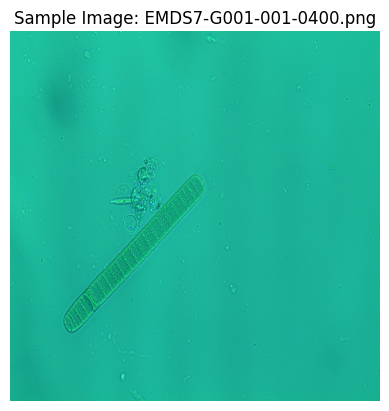

Annotations for EMDS7-G001-001-0400.png:
  Label: G001, Bounding Box: (285, 582, 1094, 1266)
  Label: unknown, Bounding Box: (542, 504, 840, 847)


In [ ]:
# Display sample image and its annotation
def display_sample(image_file, annotation_file):
    img_path = os.path.join(images_dir, image_file)
    annotation_path = os.path.join(annotations_dir, annotation_file)

    # Open and display image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Sample Image: {image_file}")
    plt.show()

    # Parse and display annotations
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    print(f"Annotations for {image_file}:")
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        print(f"  Label: {label}, Bounding Box: "
              f"({bbox.find('xmin').text}, {bbox.find('ymin').text}, {bbox.find('xmax').text}, {bbox.find('ymax').text})")

# Display a random sample
if image_files and annotation_files:
    display_sample(image_files[0], annotation_files[0])

Data Preprocessing

Validate image files

In [ ]:
import os
import cv2
import multiprocessing

def validate_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Corrupted image file")
        return True  # Indicate successful validation
    except Exception as e:
        print(f"Removing corrupted image: {os.path.basename(img_path)}")
        os.remove(img_path)
        return False  # Indicate failed validation

# Assuming you have image_files and images_dir defined
num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
pool = multiprocessing.Pool(processes=num_processes)

# Process image files in parallel
results = pool.map(validate_image, [os.path.join(images_dir, img_file) for img_file in image_files])

pool.close()
pool.join()

KeyboardInterrupt: 

Validate annotation files

In [ ]:
import os
import xml.etree.ElementTree as ET
import multiprocessing

def validate_annotation(ann_path):
    try:
        ET.parse(ann_path)
        return True  # Indicate successful validation
    except Exception as e:
        print(f"Removing invalid annotation: {os.path.basename(ann_path)}")
        os.remove(ann_path)
        return False  # Indicate failed validation

# Assuming you have annotation_files and annotations_dir defined
num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
pool = multiprocessing.Pool(processes=num_processes)

# Process annotation files in parallel
results = pool.map(validate_annotation, [os.path.join(annotations_dir, ann_file) for ann_file in annotation_files])

pool.close()
pool.join()

Resize the images

In [ ]:
# Define output directory
import os
processed_images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"
os.makedirs(processed_images_dir, exist_ok=True)

# Get the image files again
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Assuming this is the path to your images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".png")])

# Import cv2 here
import cv2

# Resize and normalize
input_size = (640, 640)  # Resize dimensions
for img_file in image_files:
    img_path = os.path.join(images_dir, img_file)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, input_size)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    processed_img_path = os.path.join(processed_images_dir, img_file)
    cv2.imwrite(processed_img_path, (img_normalized * 255).astype("uint8"))  # Save processed image

Data Augmentation

In [ ]:
from PIL import Image, ImageEnhance  # Import Image and ImageEnhance from PIL
import os  # Import os for file system operations
# Define augmentation directory
augmented_images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7/augmented_images"
os.makedirs(augmented_images_dir, exist_ok=True)

# Augmentation functions
def augment_image(img_path, output_path):
    img = Image.open(img_path)

    # Apply augmentations
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
    bright_img = ImageEnhance.Brightness(img).enhance(1.5)  # Increase brightness
    rotated_img = img.rotate(15)  # Rotate by 15 degrees

    # Save augmented images
    flipped_img.save(output_path.replace(".png", "_flipped.png"))
    bright_img.save(output_path.replace(".png", "_bright.png"))
    rotated_img.save(output_path.replace(".png", "_rotated.png"))

# Apply augmentations to all images
for img_file in image_files:
    img_path = os.path.join(images_dir, img_file)
    output_path = os.path.join(augmented_images_dir, img_file)
    augment_image(img_path, output_path)

VOC to YOLO conversion

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import pandas as pd

labels_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"

def convert_voc_to_yolo(annotation_path, image_path, output_path):
    # Parse VOC XML and convert to YOLO format
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    img = Image.open(image_path)
    img_width, img_height = img.size

    yolo_annotations = []
    for obj in root.findall("object"):
        label = obj.find("name").text

        # Check if the label is in class_mapping
        if label in class_mapping:
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # YOLO format
            x_center = ((xmin + xmax) / 2) / img_width
            y_center = ((ymin + ymax) / 2) / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            class_id = class_mapping[label]  # Map label to class ID
            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
        else:
            print(f"Warning: Label '{label}' not found in class_mapping, skipping this object...")

    # Save YOLO annotations
    with open(output_path, "w") as f:
        f.write("\n".join(yolo_annotations))

# Convert all annotations (example)
for ann_file in os.listdir(labels_dir):
    voc_path = os.path.join(labels_dir, ann_file)
    img_path = os.path.join(images_dir, ann_file.replace(".xml", ".png"))
    yolo_path = os.path.join(labels_dir, ann_file.replace(".xml", ".txt"))
    convert_voc_to_yolo(voc_path, img_path, yolo_path)

Splitting dataset into training and Val

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os

# Define paths
images_path = "/content/drive/MyDrive/Colab/FY_project/EMDS7" # Path to original images
yolo_labels_path = "/content/drive/MyDrive/Colab/FY_project/labels" # Path to YOLO labels

train_images = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/train/images"
val_images = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/val/images"
train_labels = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/train/labels"
val_labels = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/val/labels"

# Create directories if they don't exist
os.makedirs(train_images, exist_ok=True)
os.makedirs(val_images, exist_ok=True)
os.makedirs(train_labels, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

# List all images and labels
images = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
labels = sorted([f.replace('.png', '.txt') for f in images])

# Split into train and validation sets
train_images_list, val_images_list, train_labels_list, val_labels_list = train_test_split(images, labels, test_size=0.2, random_state=42)

# Move files
for img, lbl in zip(train_images_list, train_labels_list):
    shutil.move(os.path.join(images_path, img), train_images)
    shutil.move(os.path.join(yolo_labels_path, lbl), train_labels)

for img, lbl in zip(val_images_list, val_labels_list):
    shutil.move(os.path.join(images_path, img), val_images)
    shutil.move(os.path.join(yolo_labels_path, lbl), val_labels)

Creating data.yaml file

In [ ]:
# Updated names list for pathogens
names_list = ['Oscillatoria', 'Ankistrodesmus', 'Microcystis', 'Gomphonema', 'Sphaerocystis',
              'Cosmarium', 'Cocconeis', 'Tribonema', 'Chlorella', 'Tetraedron', 'Ankistrodesmus',
              'Brachionus', 'Chaenea', 'Pediastrum', 'Spirulina', 'Actinastrum', 'Navicula',
              'Scenedesmus', 'Golenkinia', 'Pinnularia', 'Staurastrum', 'Phormidium', 'Fragilaria',
              'Anabaenopsis', 'Coelosphaerium', 'Crucigenia', 'Achnanthes', 'Synedra', 'Ceratium',
              'Pompholyx', 'Merismopedia', 'Spirogyra', 'Coelastrum', 'Raphidiopsis', 'Gomphosphaeria',
              'Euglena', 'Euclanis', 'Keratella', 'diversicornis', 'Surirella', 'Characium']

# Define paths from your original code
train_images = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/train/images"
val_images = "/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/val/images"

# Define the content of the data.yaml file using the specified paths
yaml_content = f"""
train: {train_images}
val: {val_images}

nc: 41  # Number of classes
names: ["""

# Iterate through the names list and add each name to the yaml content
for i, name in enumerate(names_list):
    yaml_content += f"'{name}'"  # Added quotes around the name
    if i < len(names_list) - 1:  # Add comma if not the last element
        yaml_content += ", "

yaml_content += "]\n"  # Closing the list

# Write to the data.yaml file in the EMDS7_dataset directory
with open('/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/data.yaml', 'w') as file:
    file.write(yaml_content)

print("data.yaml file has been created successfully!")

data.yaml file has been created successfully!


Contents in data.yaml file

In [ ]:
!pip install pyyaml  # Install pyyaml if you haven't already

import yaml  # Import the yaml module

# Path to your data.yaml file
yaml_file_path = '/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/data.yaml'

# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    try:
        data = yaml.safe_load(file)  # Load the YAML data
        print(data)  # Print the contents
    except yaml.YAMLError as exc:
        print(exc)  # Print any errors during loading

Harmful and Non-harmful Pathogens

Mapping 0 as Not-Harmful and 1 as Harmful

In [ ]:
import pandas as pd

# Load the class mapping from the CSV file
class_mapping_df = pd.read_csv('/content/drive/MyDrive/Colab/FY_project/class_mapping.csv')

# Replace 0 and 1 with "Not Harmful" and "Harmful"
class_mapping_df['Harmful'] = class_mapping_df['Harmful'].replace({0: 'Not Harmful', 1: 'Harmful'})

# Replace missing values with "Missing"
class_mapping_df['Harmful'] = class_mapping_df['Harmful'].fillna('Missing')

# Display the DataFrame in a table format
from IPython.display import display, HTML  # Import necessary modules
display(HTML(class_mapping_df[['Class Name', 'Harmful']].to_html(index=False)))  # Display as HTML table

Class Name,Harmful
Oscillatoria,Harmful
Ankistrodesmus,Not Harmful
Microcystis,Harmful
Gomphonema,Not Harmful
Sphaerocystis,Not Harmful
Cosmarium,Not Harmful
Cocconeis,Not Harmful
Tribonema,Not Harmful
Chlorella,Not Harmful
Tetraedron,Not Harmful


Create a bar plot showing Pathogenicity harmful_counts

In [ ]:
# This is the cell where the error occurred
# Import necessary libraries
import pandas as pd
import plotly.express as px

# --- Code to generate the bar plot ---
harmful_counts = class_mapping_df['Harmful'].value_counts().reset_index()
harmful_counts.columns = ['Harmful', 'Count']

fig = px.bar(harmful_counts, x='Harmful', y='Count',
             title='Pathogenicity Distribution', color="Harmful",
             color_discrete_sequence=["green", "red", "yellow"])
fig.update_xaxes(title_text="Pathogenicity")
fig.update_yaxes(title_text="No. of Classes")

# Show the plot
fig.show()

Pie chart to display pathogenicity

In [ ]:
# Create a pie chart showing Pathogenicity
fig = px.pie(harmful_counts, values='Count', names='Harmful',
             color='Harmful', color_discrete_sequence=["green", "red", "yellow"],
             title='Pathogenicity Distribution')

# Show the pie chart
fig.show()

# Bar Plot showing Image Distribution across each EM class


In [ ]:
# prompt: Bar Plot showing Image Distribution across each EM class

import plotly.express as px

# Assuming 'class_mapping_counts_df' is your DataFrame from the previous code
fig = px.bar(class_mapping_counts_df, x='Class Name', y='Image Count',
             title='Image Distribution across EM Classes',
             labels={'Class Name': 'EM Class', 'Image Count': 'Number of Images'})

fig.update_xaxes(categoryorder='total descending') # Order bars by image count
fig.show()

In [ ]:
# Bar Plot showing Image Distribution of bottom 5 EM class
fig = px.bar(class_mapping_counts_df.sort_values('Image Count')[0:5], x='Class Name', y='Image Count', title='Bottom 5 EM by Number of Images')
fig.update_xaxes(title_text="Environmental Microgranism(EM)")
fig.update_yaxes(title_text="No. of Images")

# Show the plot
fig.show()

Bar Plot showing Image Distribution of Top 5 EM class

In [ ]:
# Bar Plot showing Image Distribution of Top 5 EM class
fig = px.bar(class_mapping_counts_df.sort_values('Image Count')[-5:], x='Class Name', y='Image Count', title='Top 5 EM by Number of Images')
fig.update_xaxes(title_text="Environmental Microgranism(EM)")
fig.update_yaxes(title_text="No. of Images")

# Show the plot
fig.show()

EM Image Distribution with Pathogenicity

In [ ]:
#Create a bar graph
# Ensure 'class_mapping_counts_df' has the 'Harmful' column
if 'Harmful' not in class_mapping_counts_df.columns:
  # Assuming you have a separate 'class_mapping_df' with 'Harmful' column
  class_mapping_counts_df = pd.merge(class_mapping_counts_df,
                                    class_mapping_df[['Class Name', 'Harmful']],
                                    on='Class Name', how='left')

fig = px.bar(class_mapping_counts_df,
             x='Class Name',
             y='Image Count',
             title='EM Distribution with Pathogenicity',
             color='Harmful',  # Changed to column name "Harmful"
             color_discrete_sequence=["red", "green","yellow"],
             category_orders={"Class Name": class_mapping_counts_df['Class Name'].tolist()})
fig.update_xaxes(title_text="Environmental Microgranism(EM)")
fig.update_yaxes(title_text="No. of Images")

# Show the plot
fig.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

def get_image_paths(images_dir):
    """
    Gets the paths of all PNG images in the specified directory.

    Args:
        images_dir: The directory containing the images.

    Returns:
        A list of image paths.
    """
    image_paths = []
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(images_dir, filename)
            image_paths.append(image_path)
    return image_paths

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Replace with your actual images directory
image_paths = get_image_paths(images_dir)
print(image_paths) # To see the output, run the code.

import os
import pandas as pd

def get_image_paths_by_type(images_dir, class_mapping_counts_df, type):
    """
    Gets the paths of images of a specific type (Harmful/Not Harmful).

    Args:
        images_dir: The directory containing the images.
        class_mapping_counts_df: The DataFrame containing class mapping and counts.
        type: The type of images to retrieve ("Harmful" or "Not Harmful").

    Returns:
        A list of image paths of the specified type.
    """

    image_paths = []
    for index, row in class_mapping_counts_df.iterrows():
        if row['Harmful'] == type:
            class_name = row['Class Name']  # Get the class name from the DataFrame
            for filename in os.listdir(images_dir):
                if filename.endswith(".png") and class_name in filename:
                    image_path = os.path.join(images_dir, filename)
                    image_paths.append(image_path)
                    break  # Move to the next class once an image is found
    return image_paths

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Path to your images
# Assuming 'class_mapping_counts_df' is already defined
harmful_image_paths = get_image_paths_by_type(images_dir, class_mapping_counts_df, "Harmful")
not_harmful_image_paths = get_image_paths_by_type(images_dir, class_mapping_counts_df, "Not Harmful")


def plot_images(image_paths,type):
    # Calculate the number of rows and columns for the grid
    num_images = len(image_paths)
    num_rows = int(num_images ** 0.5)  # Square root of the number of images
    num_cols = (num_images + num_rows - 1) // num_rows  # Ensure enough columns
    df = class_mapping_counts_df[class_mapping_counts_df['Harmful'] == type].reset_index()

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

    # Loop through the image paths and display each image in a subplot
    for i, image_path in enumerate(image_paths):
        # Load the image using plt.imread()
        image = imread(image_path)

        # Calculate the row and column index for this subplot
        row = i // num_cols
        col = i % num_cols

        # Display the image in the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].set_title(df['Class Name'][i]+ " (" + df['Folder Name'][i].split('-')[1] + ")")  # Optional: Add titles

    # Hide any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    # Adjust the layout to prevent overlapping titles
    plt.tight_layout()

    # Show the grid of images
    plt.show()

['/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-099-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-098-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-100-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-101-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-102-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-103-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-105-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-104-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-107-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-106-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-108-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-109-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMDS7-G022-111-0400.png', '/content/drive/MyDrive/Colab/FY_project/EMDS7/EMD

Displaying Harmful Pathogens

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import re

# Path to your class_mapping.csv file
class_mapping_csv_path = "/content/drive/MyDrive/Colab/FY_project/class_mapping.csv"

def plot_all_harmful_pathogens(images_dir):
    """Plots all harmful pathogens with their images and image names."""

    # Load class mapping to get harmful classes
    class_mapping_df = pd.read_csv(class_mapping_csv_path)
    harmful_class_names = class_mapping_df[class_mapping_df['Harmful'] == 1]['Class ID'].tolist()

    # Get all image paths
    all_image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')]

    # Filter for harmful image paths (using regex and class names)
    harmful_image_paths = []
    for img_path in all_image_paths:
        img_name = os.path.basename(img_path)
        # Check if any part of the image name matches any harmful class folder name
        if any(re.search(class_name, img_name) for class_name in harmful_class_names):
            harmful_image_paths.append(img_path)

    # Check if harmful images were found
    if not harmful_image_paths:
        print("No images of harmful pathogens found.")
        return

    # Calculate grid dimensions
    num_harmful = len(harmful_image_paths)
    num_cols = 6  # Fixed number of columns
    num_rows = (num_harmful + num_cols - 1) // num_cols  # Calculate rows needed

    # Create subplots and display images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2.5 * num_rows),  # Adjusted figsize
                               gridspec_kw={'hspace': 0.5, 'wspace': 0.3})  # Added spacing

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i, image_path in enumerate(harmful_image_paths):
        try:
            image = imread(image_path)
            # Call imshow and set_title on the pyplot object (plt)
            # or on the specific axes object (axes[i]) if you created subplots
            plt.subplot(num_rows, num_cols, i + 1) # Activate the subplot
            plt.imshow(image)
            plt.title(os.path.basename(image_path)) # Set the title for this subplot
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {image_path}: {e}")
            plt.subplot(num_rows, num_cols, i + 1)
            plt.title(f"Error: {os.path.basename(image_path)}") # Set the error title
            plt.axis('off')

    # Hide empty subplots
    for j in range(num_harmful, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"
plot_all_harmful_pathogens(images_dir)

Importing the YOLOv5 from ultralytics

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.11 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Training the model

In [ ]:
%cd /content/yolov5


/content/yolov5


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os

print("\n========== SECTION 1: Setup and Configuration ==========")

class Config:
    DATASET_PATH = '/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset'  # Updated path
    TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
    TEST_DIR = os.path.join(DATASET_PATH, 'val') # Assuming 'val' is your test set
    CLASSES = ['Oscillatoria', 'Ankistrodesmus', 'Microcystis', 'Gomphonema', 'Sphaerocystis',
              'Cosmarium', 'Cocconeis', 'Tribonema', 'Chlorella', 'Tetraedron', 'Ankistrodesmus',
              'Brachionus', 'Chaenea', 'Pediastrum', 'Spirulina', 'Actinastrum', 'Navicula',
              'Scenedesmus', 'Golenkinia', 'Pinnularia', 'Staurastrum', 'Phormidium', 'Fragilaria',
              'Anabaenopsis', 'Coelosphaerium', 'Crucigenia', 'Achnanthes', 'Synedra', 'Ceratium',
              'Pompholyx', 'Merismopedia', 'Spirogyra', 'Coelastrum', 'Raphidiopsis', 'Gomphosphaeria',
              'Euglena', 'Euclanis', 'Keratella', 'diversicornis', 'Surirella', 'Characium']  # Your EMDS7 classes
    CONF_THRESHOLD = 0.25
    BATCH_SIZE = 16
    IMG_SIZE = 640

model = YOLO('/content/yolov5/yolov5su.pt')  # Assuming your YOLOv5 model is here
print("Model loaded successfully!")


========== SECTION 1: Setup and Configuration ==========
PRO TIP 💡 Replace 'model=/content/yolov5/yolov5s.pt' with new 'model=/content/yolov5/yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 66.7MB/s]

Model loaded successfully!


In [ ]:
!python train.py --img 412 --batch 32 --epochs 10 --data '/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/data.yaml' --cfg ./models/yolov5s.yaml --weights 'yolov5s.pt' --device 0

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-03 05:11:08.809978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738559468.830216    2069 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738559468.836485    2069 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: iamkotarosmom191997 (iamkotarosmom191997-bnm-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/drive/MyDrive/EMDS7_Project/EMDS7_dat

Training for 25 epochs

In [ ]:
!python train.py --img 412 --batch 32 --epochs 25 --data '/content/drive/MyDrive/EMDS7_Project/EMDS7_dataset/data.yaml' --cfg ./models/yolov5s.yaml --weights 'yolov5s.pt' --device 0

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-18 05:23:21.509092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739856201.752647    1728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739856201.816651    1728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

Displaying the pathogen and disease caused by it

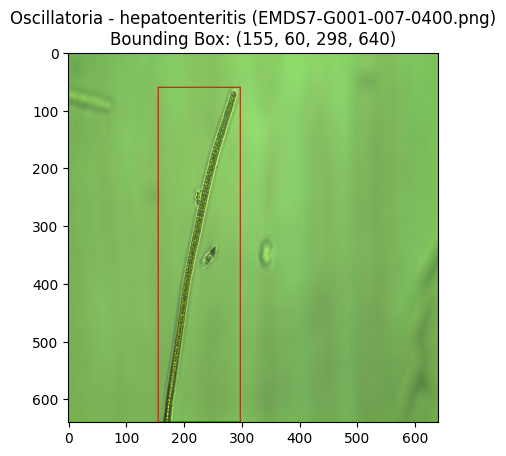

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import re

# Define input size used during resizing
input_size = (640, 640)

# Define a dictionary to store harmful pathogen information
harmful_pathogens = {
    "G001": {"name": "Oscillatoria", "disease": "hepatoenteritis"},
    "G003": {"name": "Microcystis", "disease": "Microcystin Toxicity Syndrome"},
    "G014": {"name": "Pediastrum", "disease": "skin irritation"},
    "G021": {"name": "Staurastrum", "disease": "biofouling-related dermatitis"},
    "G022": {"name": "Phormidium", "disease": "Neurotoxic Cyanobacterial Poisoning"},
    "G023": {"name": "Fragilaria", "disease": "Amnesic Shellfish Poisoning (ASP)"},
    "G024": {"name": "Anabaenopsis", "disease": "muscle twitching"},
    "G025": {"name": "Coelosphaerium", "disease": "liver toxicity and gastrointestinal illness"},
    "G031": {"name": "Merismopedia", "disease": "hypersensitivity pneumonitis"},
    "G034": {"name": "Raphidiopsis", "disease": "liver and kidney damage"},
    "G035": {"name": "Gomphosphaeria", "disease": "hepatotoxicity and gastrointestinal distress"},
    "G036": {"name": "Euglena", "disease": "Euglenophycin Toxicity"},
}

def display_pathogen_info(class_id, images_dir, annotations_dir):
    """
    Displays information about a harmful pathogen, including its image,
    bounding box, name, and associated disease, with adjusted coordinates
    for resized images.

    Args:
        class_id: The class ID of the harmful pathogen (e.g., "G001").
        images_dir: Directory containing the images.
        annotations_dir: Directory containing the annotations.
    """
    if class_id in harmful_pathogens:
        pathogen_info = harmful_pathogens[class_id]
        pathogen_name = pathogen_info["name"]
        disease = pathogen_info["disease"]

        # Find image and annotation files for the given class ID using regex
        image_path = None
        annotation_path = None
        image_filename = None

        # Create a regex pattern to match filenames with the class ID
        pattern = re.compile(rf"EMDS7-{class_id}-\d{{3}}-\d{{4}}.png")

        for filename in os.listdir(images_dir):
            if pattern.match(filename):  # Use regex to find matching filenames
                image_path = os.path.join(images_dir, filename)
                annotation_path = os.path.join(annotations_dir, filename.replace(".png", ".xml"))
                image_filename = filename  # Store the filename
                break  # Found the image and annotation, exit loop

        # Check if image_path was assigned a value
        if image_path is None:
            print(f"Error: No image found for class ID '{class_id}' in the images directory.")
            return

        # Open image and annotation
        img = Image.open(image_path)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get bounding box coordinates and adjust for resizing
        bbox_coords = None
        for obj in root.findall('object'):
            if obj.find('name').text == class_id:
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Get original image size from annotation
                orig_width = int(root.find('size').find('width').text)
                orig_height = int(root.find('size').find('height').text)

                # Adjust bounding box coordinates to resized image
                xmin = int(xmin * (input_size[0] / orig_width))
                ymin = int(ymin * (input_size[1] / orig_height))
                xmax = int(xmax * (input_size[0] / orig_width))
                ymax = int(ymax * (input_size[1] / orig_height))

                bbox_coords = (xmin, ymin, xmax, ymax)  # Store adjusted coordinates
                break  # Found bounding box, exit loop

        # Resize the image
        img = img.resize(input_size)

        # Display image and bounding box with filename and coordinates in title
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox_coords, outline="red", width=2)  # Draw bounding box
        plt.imshow(img)
        plt.title(f"{pathogen_name} - {disease} ({image_filename})\nBounding Box: {bbox_coords}")
        plt.show()

    else:
        print(f"Error: Class ID '{class_id}' not found in harmful pathogens list.")

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Replace with your actual images directory
annotations_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"  # Replace with your actual annotations directory

display_pathogen_info("G001", images_dir, annotations_dir)  # Example: Display info for Oscillatoria (G001)

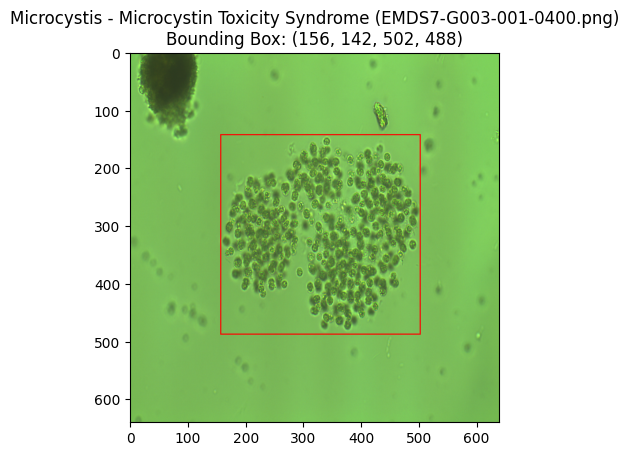

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import re

# Define input size used during resizing
input_size = (640, 640)

# Define a dictionary to store harmful pathogen information
harmful_pathogens = {
    "G001": {"name": "Oscillatoria", "disease": "hepatoenteritis"},
    "G003": {"name": "Microcystis", "disease": "Microcystin Toxicity Syndrome"},
    "G014": {"name": "Pediastrum", "disease": "skin irritation"},
    "G021": {"name": "Staurastrum", "disease": "biofouling-related dermatitis"},
    "G022": {"name": "Phormidium", "disease": "Neurotoxic Cyanobacterial Poisoning"},
    "G023": {"name": "Fragilaria", "disease": "Amnesic Shellfish Poisoning (ASP)"},
    "G024": {"name": "Anabaenopsis", "disease": "muscle twitching"},
    "G025": {"name": "Coelosphaerium", "disease": "liver toxicity and gastrointestinal illness"},
    "G031": {"name": "Merismopedia", "disease": "hypersensitivity pneumonitis"},
    "G034": {"name": "Raphidiopsis", "disease": "liver and kidney damage"},
    "G035": {"name": "Gomphosphaeria", "disease": "hepatotoxicity and gastrointestinal distress"},
    "G036": {"name": "Euglena", "disease": "Euglenophycin Toxicity"},
}

def display_pathogen_info(class_id, images_dir, annotations_dir):
    """
    Displays information about a harmful pathogen, including its image,
    bounding box, name, and associated disease, with adjusted coordinates
    for resized images.

    Args:
        class_id: The class ID of the harmful pathogen (e.g., "G003").
        images_dir: Directory containing the images.
        annotations_dir: Directory containing the annotations.
    """
    if class_id in harmful_pathogens:
        pathogen_info = harmful_pathogens[class_id]
        pathogen_name = pathogen_info["name"]
        disease = pathogen_info["disease"]

        # Find image and annotation files for the given class ID using regex
        image_path = None
        annotation_path = None
        image_filename = None

        # Create a regex pattern to match filenames with the class ID
        pattern = re.compile(rf"EMDS7-{class_id}-\d{{3}}-\d{{4}}.png")

        for filename in os.listdir(images_dir):
            if pattern.match(filename):  # Use regex to find matching filenames
                image_path = os.path.join(images_dir, filename)
                annotation_path = os.path.join(annotations_dir, filename.replace(".png", ".xml"))
                image_filename = filename  # Store the filename
                break  # Found the image and annotation, exit loop

        # Check if image_path was assigned a value
        if image_path is None:
            print(f"Error: No image found for class ID '{class_id}' in the images directory.")
            return

        # Open image and annotation
        img = Image.open(image_path)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get bounding box coordinates and adjust for resizing
        bbox_coords = None
        for obj in root.findall('object'):
            if obj.find('name').text == class_id:
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Get original image size from annotation
                orig_width = int(root.find('size').find('width').text)
                orig_height = int(root.find('size').find('height').text)

                # Adjust bounding box coordinates to resized image
                xmin = int(xmin * (input_size[0] / orig_width))
                ymin = int(ymin * (input_size[1] / orig_height))
                xmax = int(xmax * (input_size[0] / orig_width))
                ymax = int(ymax * (input_size[1] / orig_height))

                bbox_coords = (xmin, ymin, xmax, ymax)  # Store adjusted coordinates
                break  # Found bounding box, exit loop

        # Resize the image
        img = img.resize(input_size)

        # Display image and bounding box with filename and coordinates in title
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox_coords, outline="red", width=2)  # Draw bounding box
        plt.imshow(img)
        plt.title(f"{pathogen_name} - {disease} ({image_filename})\nBounding Box: {bbox_coords}")
        plt.show()

    else:
        print(f"Error: Class ID '{class_id}' not found in harmful pathogens list.")

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Replace with your actual images directory
annotations_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"  # Replace with your actual annotations directory

display_pathogen_info("G003", images_dir, annotations_dir)  # Display info for Microcystis (G003)

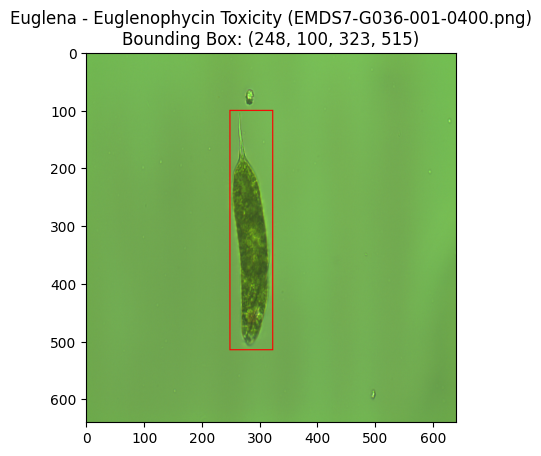

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import re

# Define input size used during resizing
input_size = (640, 640)

# Define a dictionary to store harmful pathogen information
harmful_pathogens = {
    "G001": {"name": "Oscillatoria", "disease": "hepatoenteritis"},
    "G003": {"name": "Microcystis", "disease": "Microcystin Toxicity Syndrome"},
    "G014": {"name": "Pediastrum", "disease": "skin irritation"},
    "G021": {"name": "Staurastrum", "disease": "biofouling-related dermatitis"},
    "G022": {"name": "Phormidium", "disease": "Neurotoxic Cyanobacterial Poisoning"},
    "G023": {"name": "Fragilaria", "disease": "Amnesic Shellfish Poisoning (ASP)"},
    "G024": {"name": "Anabaenopsis", "disease": "muscle twitching"},
    "G025": {"name": "Coelosphaerium", "disease": "liver toxicity and gastrointestinal illness"},
    "G031": {"name": "Merismopedia", "disease": "hypersensitivity pneumonitis"},
    "G034": {"name": "Raphidiopsis", "disease": "liver and kidney damage"},
    "G035": {"name": "Gomphosphaeria", "disease": "hepatotoxicity and gastrointestinal distress"},
    "G036": {"name": "Euglena", "disease": "Euglenophycin Toxicity"},
}

def display_pathogen_info(class_id, images_dir, annotations_dir):
    """
    Displays information about a harmful pathogen, including its image,
    bounding box, name, and associated disease, with adjusted coordinates
    for resized images.

    Args:
        class_id: The class ID of the harmful pathogen (e.g., "G036").
        images_dir: Directory containing the images.
        annotations_dir: Directory containing the annotations.
    """
    if class_id in harmful_pathogens:
        pathogen_info = harmful_pathogens[class_id]
        pathogen_name = pathogen_info["name"]
        disease = pathogen_info["disease"]

        # Find image and annotation files for the given class ID using regex
        image_path = None
        annotation_path = None
        image_filename = None

        # Create a regex pattern to match filenames with the class ID
        pattern = re.compile(rf"EMDS7-{class_id}-\d{{3}}-\d{{4}}.png")

        for filename in os.listdir(images_dir):
            if pattern.match(filename):  # Use regex to find matching filenames
                image_path = os.path.join(images_dir, filename)
                annotation_path = os.path.join(annotations_dir, filename.replace(".png", ".xml"))
                image_filename = filename  # Store the filename
                break  # Found the image and annotation, exit loop

        # Check if image_path was assigned a value
        if image_path is None:
            print(f"Error: No image found for class ID '{class_id}' in the images directory.")
            return

        # Open image and annotation
        img = Image.open(image_path)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get bounding box coordinates and adjust for resizing
        bbox_coords = None
        for obj in root.findall('object'):
            if obj.find('name').text == class_id:
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Get original image size from annotation
                orig_width = int(root.find('size').find('width').text)
                orig_height = int(root.find('size').find('height').text)

                # Adjust bounding box coordinates to resized image
                xmin = int(xmin * (input_size[0] / orig_width))
                ymin = int(ymin * (input_size[1] / orig_height))
                xmax = int(xmax * (input_size[0] / orig_width))
                ymax = int(ymax * (input_size[1] / orig_height))

                bbox_coords = (xmin, ymin, xmax, ymax)  # Store adjusted coordinates
                break  # Found bounding box, exit loop

        # Resize the image
        img = img.resize(input_size)

        # Display image and bounding box with filename and coordinates in title
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox_coords, outline="red", width=2)  # Draw bounding box
        plt.imshow(img)
        plt.title(f"{pathogen_name} - {disease} ({image_filename})\nBounding Box: {bbox_coords}")
        plt.show()

    else:
        print(f"Error: Class ID '{class_id}' not found in harmful pathogens list.")

# Example usage:
images_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7"  # Replace with your actual images directory
annotations_dir = "/content/drive/MyDrive/Colab/FY_project/EMDS7xml"  # Replace with your actual annotations directory

display_pathogen_info("G036", images_dir, annotations_dir)  # Display info for Euglena (G036)